In [2]:
import pymc as pm 
import pandas as pd
import numpy as np
# import seaborn as sns
import arviz as az

# import theano.tensor as tt
# import aesara.tensor as at
from matplotlib import pyplot as plt

# plt.style.use('seaborn-talk')

In [3]:
pm.__version__

'5.1.2'

In [4]:
df = pd.read_csv('https://raw.githubusercontent.com/ursk/driving_fatalities/master/iihs2020.csv')

In [5]:
df.head()

,model,size,type,deaths,class,interval,MV,SV,roll,model years,exposure
0,Mitsubishi Mirage hatchback,1,car4d,72,4door,28-115,52.0,18.0,5.0,2014-17,171842
1,Kia Rio,1,car4d,87,4door,40-134,51.0,38.0,0.0,2014-17,204326
2,Hyundai Accent,1,car4d,116,4door,74-158,85.0,28.0,9.0,2014-17,417171
3,Ford Fiesta,1,car4d,141,4door,94-189,98.0,46.0,13.0,2014-17,357492
4,Volkswagen Golf,2,car4d,0,4door,0-34,0.0,0.0,0.0,2014-17,108084


In [6]:
# First question: Is this interval credible?
df[df.model == 'Subaru Outback']

,model,size,type,deaths,class,interval,MV,SV,roll,model years,exposure
80,Subaru Outback,3,wagon,3,NaN,0-6,2.0,1.0,0.0,NaN,769921


In [53]:
exposure = df['exposure'].to_numpy()
fatalities = (df['deaths']*df['exposure']).to_numpy() / 1e6  # raw fatalities
df['raw_fatalities'] = df['deaths']*df['exposure'] / 1e6

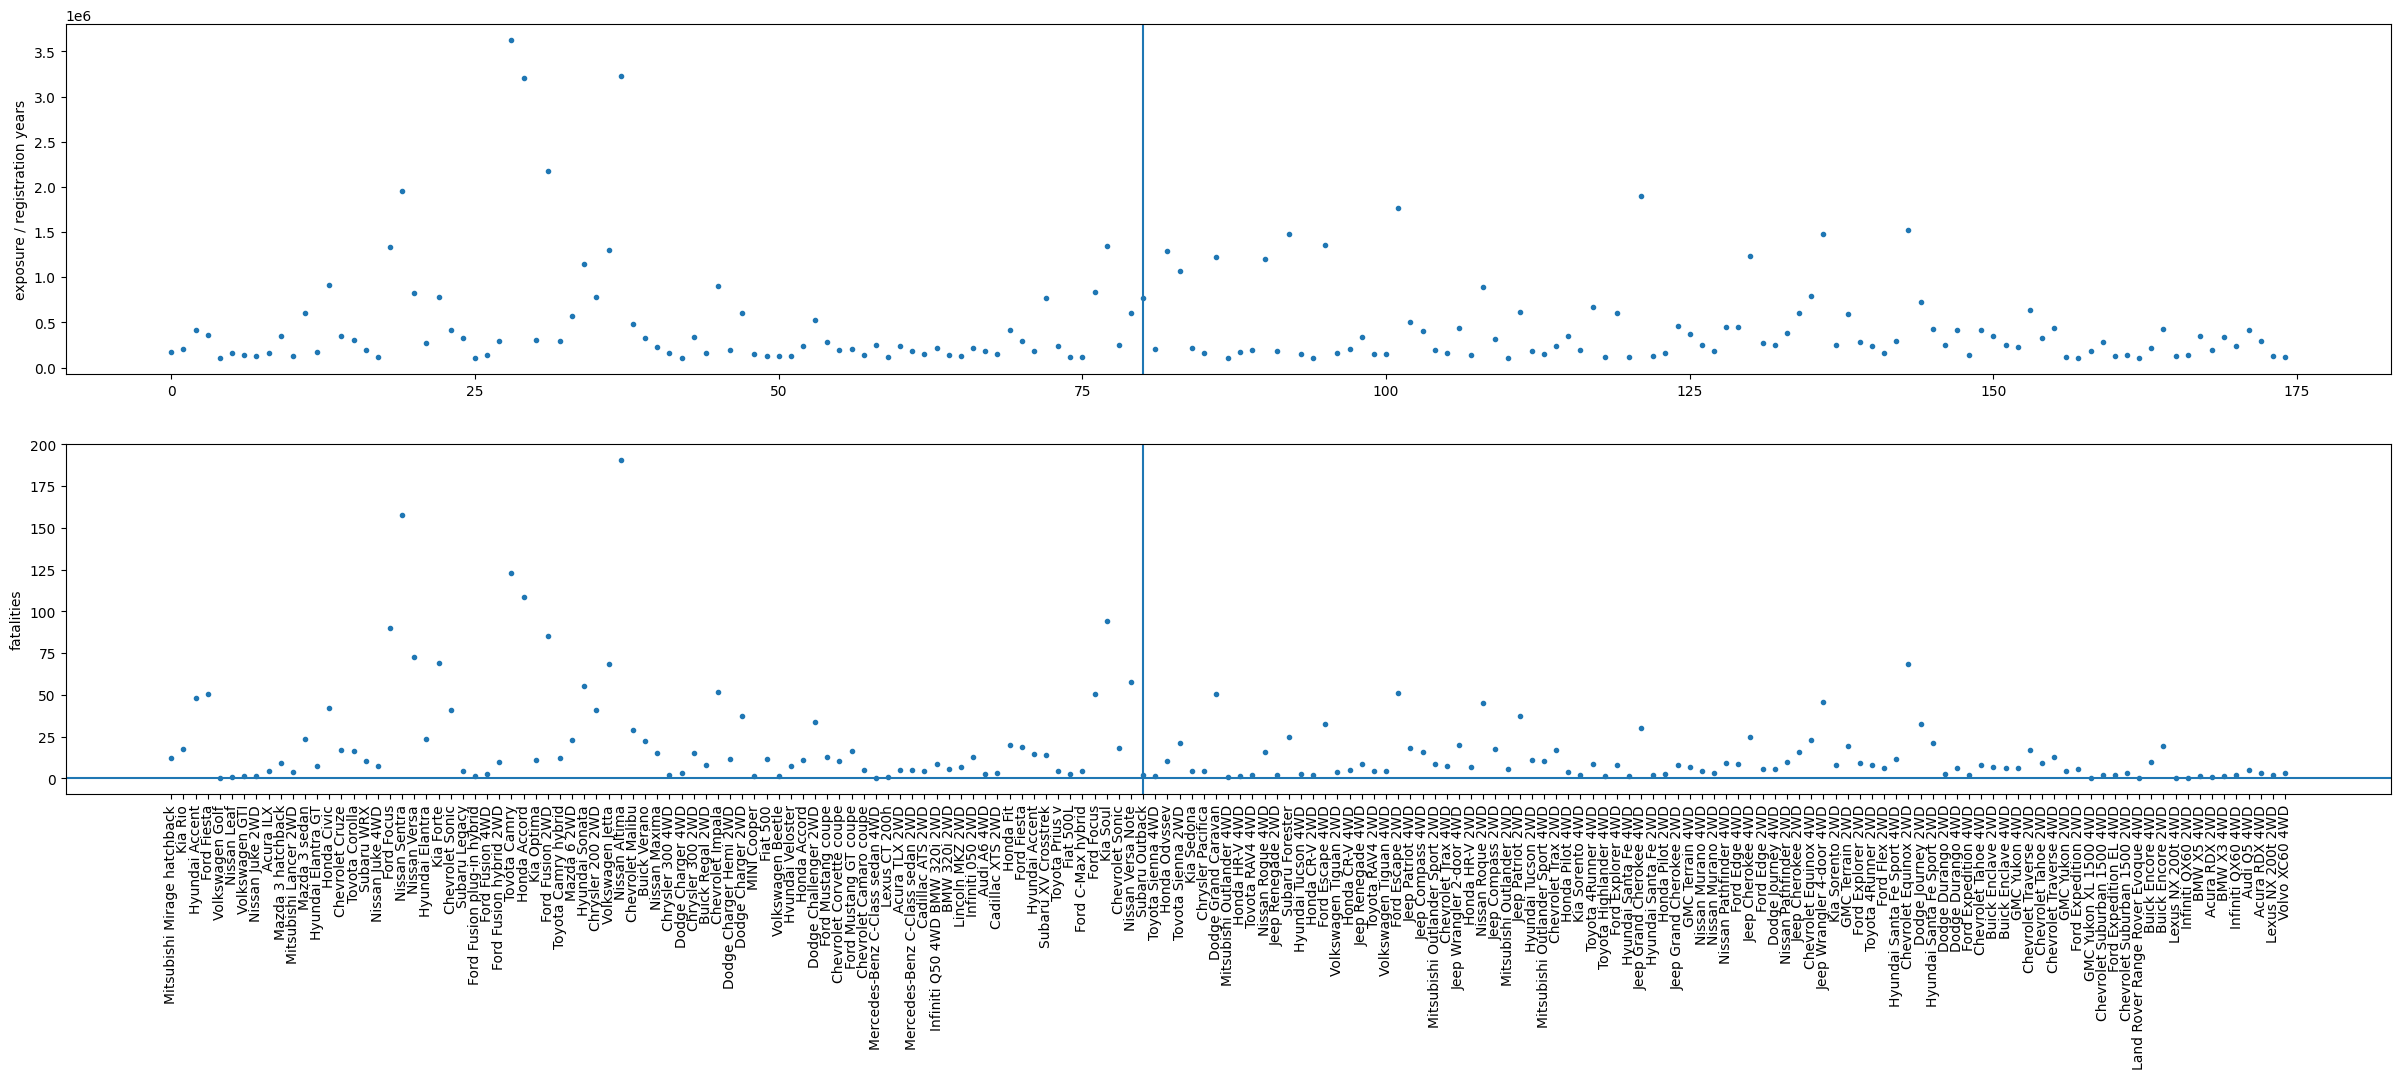

In [18]:
plt.figure(figsize=[30, 10])
plt.subplot(2, 1, 1)
plt.plot(exposure, '.')
plt.axvline(80)
plt.ylabel("exposure / registration years")

plt.subplot(2, 1, 2)
plt.plot(fatalities, '.')
plt.axhline()
plt.axvline(80)
plt.ylabel("fatalities")
plt.xticks(range(len(df)), df.model.to_numpy(), rotation='vertical')

pass

In [34]:
def car_model(exposure, fatalities):  
    with pm.Model() as model:
        pooled_rate = pm.Uniform('pooled_rate', lower=0.0, upper=1.0)
        κ_log = pm.Exponential('κ_log', lam=1.5)
        κ = pm.Deterministic('κ', np.exp(κ_log))

        model_rate = pm.Beta('model_rate', 
                             alpha=pooled_rate*κ, 
                             beta=(1.0-pooled_rate)*κ, 
                             shape=len(fatalities))
        observed_fatalities = pm.Poisson('y', mu=model_rate*exposure, observed=fatalities)


    return model

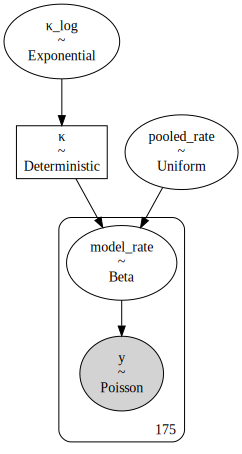

In [55]:
# m = car_model(exposure, fatalities)
m = car_model(df['exposure'], df['raw_fatalities'])

pm.model_to_graphviz(m)

In [56]:
with m:
    idata = pm.sample(1000, chains=4)

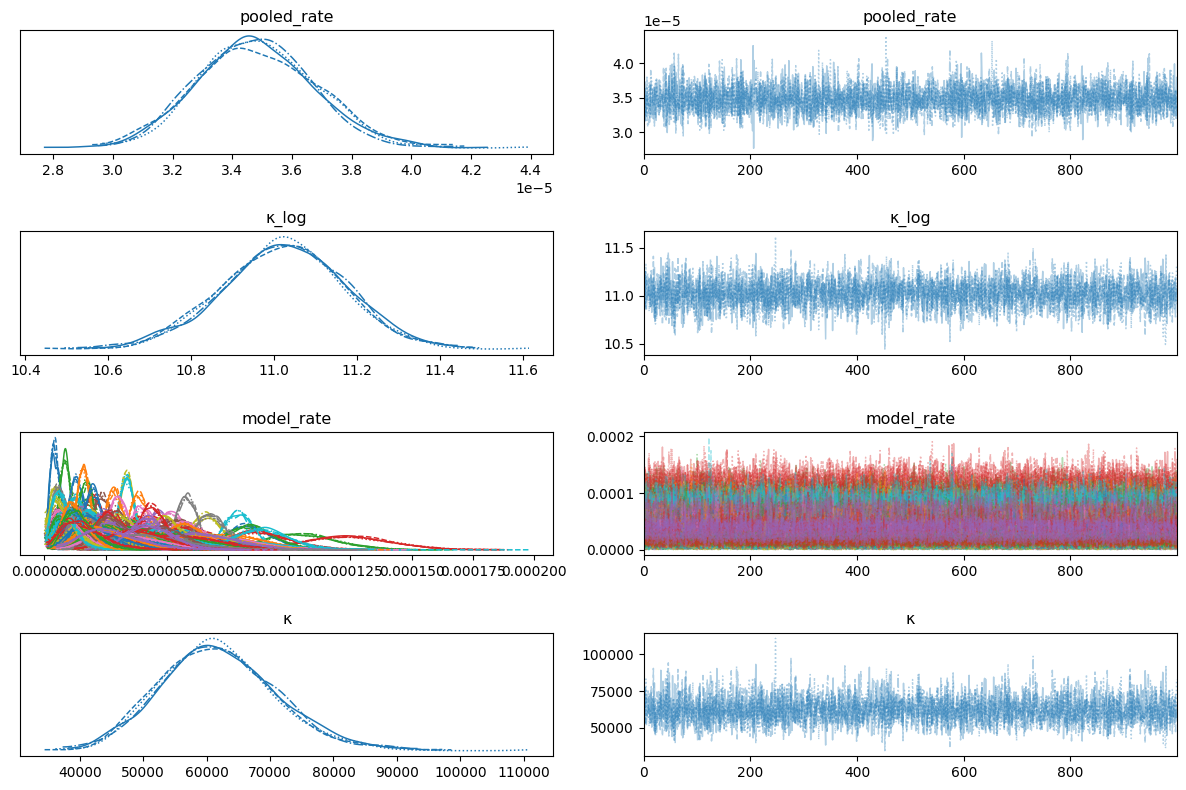

In [57]:
pm.plot_trace(idata);
plt.tight_layout()

Huge kappa -> pooled data explains the individual data well.

In [85]:
az.summary(idata.posterior.model_rate[:, :, 80:85])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
model_rate[80],0.0,0.0,0.0,0.0,0.0,0.0,5730.0,2594.0,1.0
model_rate[81],0.0,0.0,0.0,0.0,0.0,0.0,6141.0,2314.0,1.0
model_rate[82],0.0,0.0,0.0,0.0,0.0,0.0,8528.0,2654.0,1.0
model_rate[83],0.0,0.0,0.0,0.0,0.0,0.0,7296.0,2611.0,1.0
model_rate[84],0.0,0.0,0.0,0.0,0.0,0.0,6353.0,2079.0,1.0


array([<Axes: title={'center': 'model_rate\n80'}>,
       <Axes: title={'center': 'model_rate\n81'}>,
       <Axes: title={'center': 'model_rate\n82'}>], dtype=object)

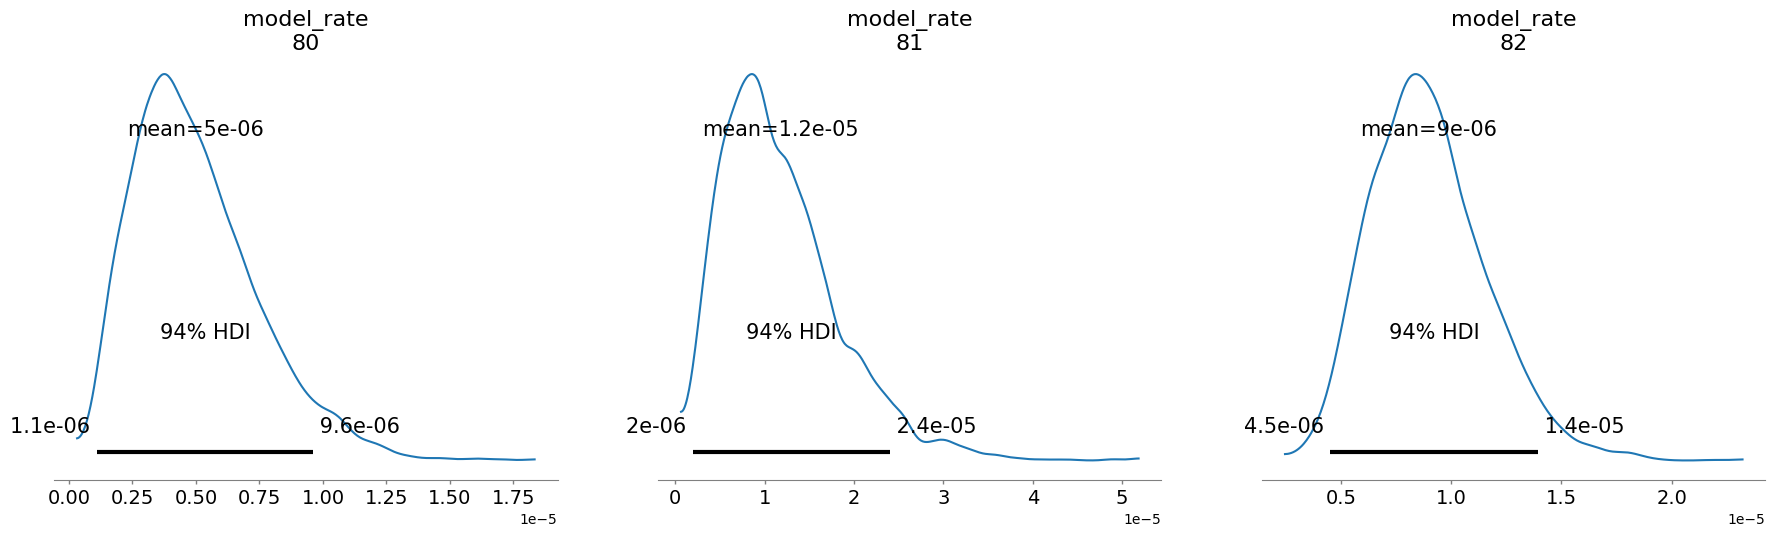

In [84]:
az.plot_posterior(idata.posterior.model_rate[:, :, 80:83], )

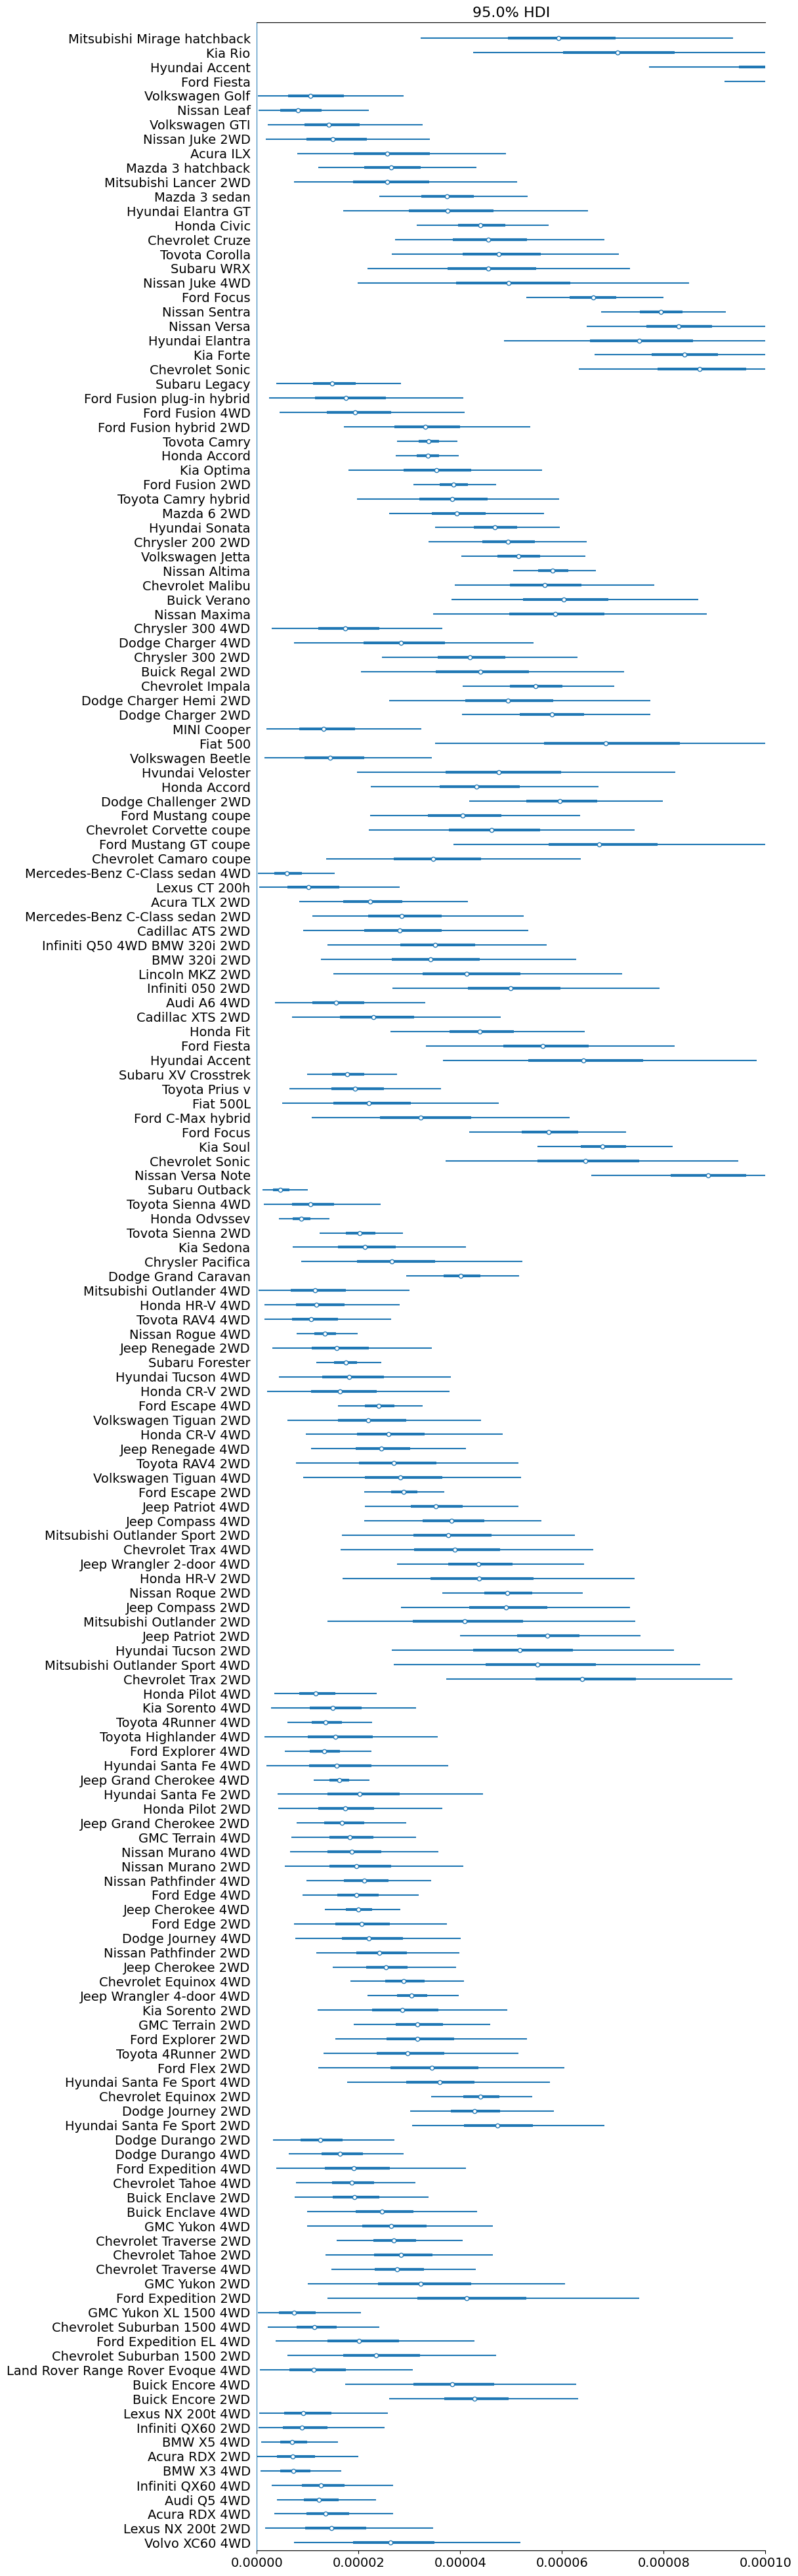

In [82]:
fig, ax = plt.subplots(figsize=[10,50])
az.plot_forest(idata.posterior.model_rate, var_names=["model_rate"], combined=True, hdi_prob=0.95, ax=ax, );
# ax.set_yticks(ax.get_yticks(), df.model.to_numpy())
ax.set_yticklabels(df.model.to_numpy()[::-1])
ax.set_xlim([0, 0.0001])
plt.axvline()
# plt.set_x
pass
